# Spam Classifier

This notebook uses a **Naive Bayes Classifier** to classify messages as spam or not spam, I want to add an implementation using no libraries or possibly a tensorflow implementation.

I chose a naive bayes classifier as I want to build the same system without libraries or using tensorflow, and this classifier is quite simple in implementation compared to alternative classifiers. It also often has a fast convergence time.

**Import necessary libraries**

In [112]:
# Basic Libraries
import os
import joblib
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt

# NLP and ML
import string
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Accuracy and testing
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit

# Analysis and Visualisation 
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

### Read the data

In [77]:
# Read and drop null values
data = pd.read_csv('../data/spam.txt')
data.dropna(how="any", inplace=True, axis=1)
data.columns = ['message', 'label']

print("The size of the data is:", data.shape)
data.head()

The size of the data is: (5728, 2)


,message,label
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


## Preliminary Analysis

In [78]:
data.label.value_counts()

0    4360
1    1368
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

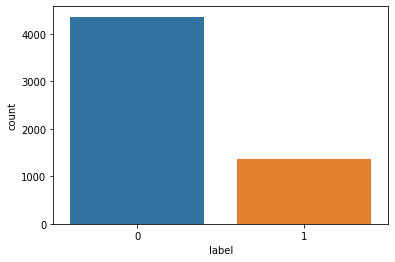

In [79]:
sns.countplot(x='label', data=data)

## Preprocessing

1. Change the text format. Save everything after the word text 
2. Add the length of the message. This is because the length of the message might have an effect on the prediction result.
3. Cleaning and stemming

In [80]:
data['message'][2]

'Subject: unbelievable new homes made easy  im wanting to show you this  homeowner  you have been pre - approved for a $ 454 , 169 home loan at a 3 . 72 fixed rate .  this offer is being extended to you unconditionally and your credit is in no way a factor .  to take advantage of this limited time opportunity  all we ask is that you visit our website and complete  the 1 minute post approval form  look foward to hearing from you ,  dorcas pittman'

In [81]:
def change_text(a):
    # Split on the colons
    x = a.split(':')
    
    # Check if there are more than 2 splits
    if len(x) > 2:
        x = ' '.join(x[1:])
        return x
    
    return x[1]

In [82]:
# Apply this change of text to the data 
data['message'] = data['message'].apply(change_text)

In [83]:
# Add the length column 
data['length'] = data['message'].apply(len)
data.head()

,message,label,length
0,naturally irresistible your corporate identit...,1,1476
1,the stock trading gunslinger fanny is merril...,1,590
2,unbelievable new homes made easy im wanting ...,1,440
3,4 color printing special request additional ...,1,492
4,"do not have money , get software cds from her...",1,227


In order to apply a model, there are some other preprocessing steps that need to be completed. For text classification, usual preprocessing includes removing STOPWORDS (words that don't provide useful meaning, i.e. "and" "or"). Also the characters are converted to a single case (the below function converts to lower case). The function below then stems each word (this means that it replaces a word with the root of that word, for example "tasted" or "tasting" would become "taste").

In [84]:
# Collect Stopwords
STOPWORDS = stopwords.words('english')
STOPWORDS

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [92]:
# Pre-Processing and cleaning function 
def clean_text(text):
    
    text=re.sub('[^a-zA-Z0-9]', ' ', a)
    
    # Remove punctuation 
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove Stopwords 
    text = [word for word in text.split() if word.lower() not in STOPWORDS]
    words = ""
    
    # Stemming 
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    
    return words

In [86]:
# Collect text features separately and preprocess them 
data['message'] = data['message'].apply(clean_text)
data.head()

,message,label,length
0,natur irresist corpor ident lt realli hard rec...,1,1476
1,stock trade gunsling fanni merril muzo colza a...,1,590
2,unbeliev new home made easi im want show homeo...,1,440
3,4 color print special request addit inform cli...,1,492
4,money get softwar cds softwar compat great gro...,1,227


**Most occuring spam words** 

This is a visualisation of the most commonly occuring spam words.

In [89]:
word=''
for i in data.index:
    if(data['label'][i]==1):
        words = nltk.word_tokenize(data['message'][i])
        for j in words:
            j.upper()
            word = word + ' ' + j

In [90]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = 'none', 
                min_font_size = 10).generate(word)

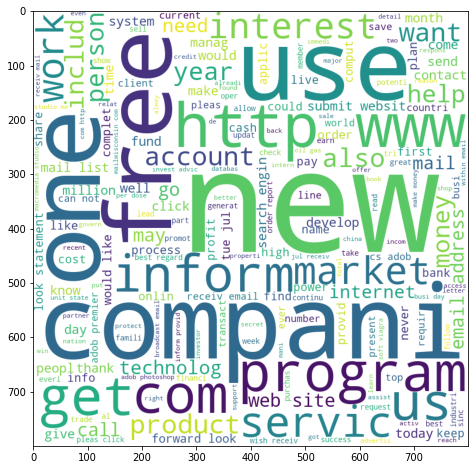

In [91]:

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)

### Vectorization

The below code uses a TFIDF vectoriser to provide useful numerical values related to the data. TFIDF (term frequency - inverse document frequency) is a statistical method to tell how important a word is to a particular document by increasing the numerical value for an occurrence in the specific document but decreasing relative to number of occurrences in the entire corpus. Similarly, I have also used a Count Vectorizer to compare which one gives better performance. 

In [101]:
# Build vectorizer instances
count_vectorizer = CountVectorizer('english')
tf_vectorizer = TfidfVectorizer('english')

In [103]:
# Extract the labels and the text
text = data['message']
labels = data['label']

In [108]:
# Vectorize the text and convert into X features
X = tf_vectorizer.fit_transform(text).toarray()
X

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.1218685, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [110]:
# We can also vectorize them using count vectorizer and call it X1
X1 = count_vectorizer.fit_transform(text).toarray()
X1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## Building and Applying ML Model

In this section, I will build the multinomial naive bayes from scratch and I will also use the Cross Validation method to confirm the accuracy. 

In [114]:
cv = ShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

In [116]:
# Finalize the model
model = MultinomialNB(alpha=0.2)

### Testing

I will be using the cross validation method which is more robust than train test split. Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. 

#### TfIdf Vectorizer

In [ ]:
# Perfrom cross validation on the complete data based on the splits made above
scores_tfidf = cross_val_score(model, X, labels, cv=cv, scoring='accuracy')
print(scores_tfidf)

In [120]:
print(scores_tfidf.mean())

KeyboardInterrupt: 

#### Count Vectorizer

In [118]:
# Perfrom cross validation on the complete data based on the splits made above
scores_count = cross_val_score(model, X1, labels, cv=cv, scoring='accuracy')
print(scores_count)

[0.98894706 0.991274   0.98603839 0.991274   0.99069226 0.9895288
 0.98894706 0.99011053 0.9947644  0.99069226]


The following code trains and test a Multinomial Naive Bayes Model using sklearn. There are many other models that may be more suitable for this dataset, however this model produce sufficient results.

In [99]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

model = MultinomialNB(alpha=0.2)
model.fit(features_train, labels_train)
prediction = model.predict(features_test)
accuracy_score(labels_test, prediction)

0.985663082437276

In [36]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

### Save the Model

In [41]:
joblib.dump(model, '../models/spam_model.sav')

['../models/spam_model.sav']

In [43]:
# load the model from disk
loaded_model = joblib.load('../models/spam_model.sav')
result = loaded_model.score(features_test, labels_test)
print(result)

0.985663082437276
